Epoch 1/100
14/14 [==============================] - 4s 106ms/step - loss: 8.9314e-05 - val_loss: 0.1093
Epoch 2/100
14/14 [==============================] - 1s 54ms/step - loss: 3.3615e-05 - val_loss: 0.0265
Epoch 3/100
14/14 [==============================] - 1s 54ms/step - loss: 1.8597e-05 - val_loss: 0.0160
Epoch 4/100
14/14 [==============================] - 1s 54ms/step - loss: 1.3632e-05 - val_loss: 0.0175
Epoch 5/100
14/14 [==============================] - 1s 54ms/step - loss: 1.6460e-05 - val_loss: 0.0202
Epoch 6/100
14/14 [==============================] - 1s 55ms/step - loss: 1.4952e-05 - val_loss: 0.0152
Epoch 7/100
14/14 [==============================] - 1s 55ms/step - loss: 1.1933e-05 - val_loss: 0.0152
Epoch 8/100
14/14 [==============================] - 1s 55ms/step - loss: 1.1522e-05 - val_loss: 0.0149
Epoch 9/100
14/14 [==============================] - 1s 58ms/step - loss: 8.8548e-06 - val_loss: 0.0161
Epoch 10/100
14/14 [==============================] - 1s 56ms/s

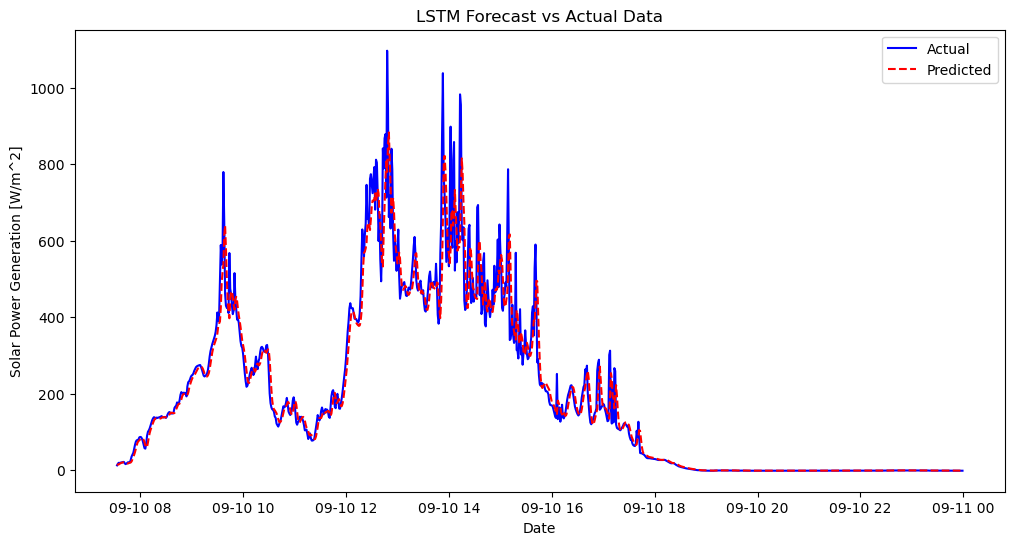

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



# Load and preprocess data
data = pd.read_csv('texas.csv')

# Create DataFrame
df = pd.DataFrame(data)

# Convert DATE to datetime format and CST to time format
df['DATE'] = pd.to_datetime(df['DATE (MM/DD/YYYY)'], format='%m/%d/%Y')
df['CST'] = pd.to_datetime(df['CST'], format='%H:%M').dt.time


# Combine DATE and CST into a single datetime column
df['Datetime'] = df.apply(lambda row: pd.Timestamp.combine(row['DATE'], row['CST']), axis=1)


df['Datetime']

df.set_index('Datetime', inplace=True)

df = df[['Global Horizontal [W/m^2]']].dropna()

# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1))

scaler = MinMaxScaler(feature_range=(0, 2))
# scaler = MinMaxScaler(feature_range=(0, 5))
# scaler = MinMaxScaler(feature_range=(0, 20))
# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 10))
# scaler = MinMaxScaler(feature_range=(0, 100))
# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 50))
# Normalize the data
# scaler = MinMaxScaler(feature_range=(0, 1000))

scaled_data = scaler.fit_transform(df)

# Create dataset for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split into training and test sets
train_size = int(len(X) * 0.3)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]



# Build and train LSTM model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=10)])


# Predict and plot results
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(12, 6))
#plt.plot(data.index[train_size + time_step:], y_test_rescaled, color='blue', label='Actual')
#plt.plot(data.index[train_size + time_step:], predictions, color='red', linestyle='--', label='Predicted')
plt.plot(df.index[train_size + time_step:], y_test_rescaled, color='blue', label='Actual')
plt.plot(df.index[train_size + time_step:], predictions, color='red', linestyle='--', label='Predicted')
plt.title('LSTM Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Solar Power Generation [W/m^2]')
plt.legend()
plt.show()